In [5]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import torch
import torch.nn as nn
from deepmeg.utils.convtools import conviter
import torch.nn.init as init
import math

import numpy as np
from typing import Callable, Sequence
from functools import partial
import matplotlib.pyplot as plt

from deepmeg.preprocessing.transforms import one_hot_encoder, zscore
from deepmeg.data.datasets import EpochsDataset

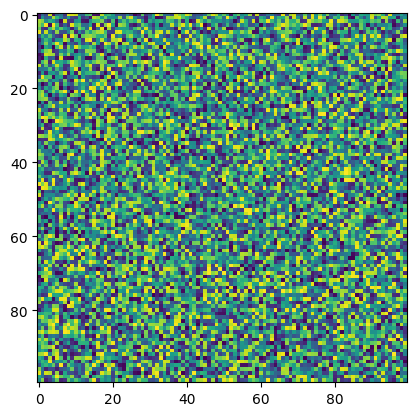

In [2]:
from deepmeg.utils.convtools import compute_output_shape


class ResConv2D(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
    ):
        super().__init__()
        self.in_channels, self.out_channels = in_channels, out_channels
        self.kernel_size = kernel_size
        self.input_size = input_size
        self.stride = stride
        self.padding = padding
        self.wave1 = nn.Parameter(torch.empty(self.in_channels, self.kernel_size[0], self.input_size[1], self.out_channels))
        self.wave2 = nn.Parameter(torch.empty(self.in_channels, self.input_size[0], self.kernel_size[1], self.out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset the layer parameters.
        Uses the Kaiming initialization method for the weight matrix and a uniform initialization method for the bias vector.
        """
        init.kaiming_uniform_(self.wave1, a=math.sqrt(5))
        init.kaiming_uniform_(self.wave2, a=math.sqrt(5))

        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.wave1)

            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)


    def forward(self, x):
        convargs = ((x.shape[-2], x.shape[-1]), self.kernel_size, self.padding, self.stride)
        out_shape = compute_output_shape(*convargs)
        out_tensor = torch.zeros(x.shape[0], self.out_channels, *out_shape)

        for n_neuron in range(self.out_channels):
            for p, q, k in conviter(*convargs):
                x_slice = x[:, :, p[0], p[1]]
                w1_slice = self.wave1[:, k[0], p[1], n_neuron]
                w2_slice = self.wave2[:, p[0], k[1], n_neuron]
                # res = torch.unsqueeze(torch.unsqueeze((w1_slice*w2_slice*x_slice).sum((1, 2, 3)), -1), -1)
                # res = torch.unsqueeze(torch.unsqueeze(((w1_slice+w2_slice)*x_slice).sum((1, 2, 3)), -1), -1)
                res = ((w1_slice + w2_slice)*x_slice).sum((1, 2, 3))
                # res = ((w1_slice + w2_slice)*x_slice).sum((1, 2, 3))
                # print(torch.squeeze(res).item(),w1_slice.item(), w2_slice.item(), x_slice.item())
                # print(out_tensor[:, n_neuron, q[-2], q[-1]].shape, res.shape)
                out_tensor[:, n_neuron, q[-2], q[-1]] = res

        return out_tensor

# X = torch.ones(10, 1, 100, 100)
# ResConv2D(1, 1, (100, 100), (1, 1), 5, 0)(X)

X = torch.rand(1, 1, 100, 100)
rc = ResConv2D(1, 1, (100, 100), (2, 1), 5, 0)
out = torch.squeeze((X).detach()).numpy()

plt.imshow(out)

In [3]:


gprob = lambda x, sigma=np.sqrt(1/5): np.exp(-(x - 1)**2/sigma**2)


def gen_2d_prob(
    center: tuple[int, int, int],
    shape: tuple[int, int, int],
    gprob: Callable[[int | Sequence, int | float], float | Sequence] = gprob
) -> np.ndarray:
    w, h = shape
    data = np.zeros(shape)

    i, j = np.meshgrid(
        np.arange(shape[0]), np.arange(shape[1]), indexing='ij'
    )

    pi = gprob(1 - np.abs(i - center[0])/w)
    pj = gprob(1 - np.abs(j - center[1])/h)
    prob = pi * pj

    mask = prob > np.random.random(size=shape)
    data[mask] = 1

    return data


def gen_2d_voxel(mask: np.ndarray, ratio: int | float = 2) -> np.ndarray:
    noise = np.random.random(mask.shape)
    return (mask*ratio + 1)*noise


def gen_2d_samples(
    shape: tuple[int, int, int],
    center: tuple[int, int, int],
    n_samples: int,
    maskgen: Callable[[int | Sequence, int | float], float | Sequence] = gprob,
    datagen: Callable[[np.ndarray, int | float], np.ndarray] = gen_2d_voxel,
) -> np.ndarray:

    return np.array([
        datagen(gen_2d_prob(center, shape, maskgen))
        for _ in range(n_samples)
    ])

In [92]:
shape = (100, 100)
sigma = .1

clases = gen_2d_samples(
    shape,
    (25, 75, 75),
    200,
    partial(gprob, sigma=sigma),
    partial(gen_2d_voxel, ratio=.25)
), gen_2d_samples(
    shape,
    (75, 75, 75),
    200,
    partial(gprob, sigma=sigma),
    partial(gen_2d_voxel, ratio=.25)
)


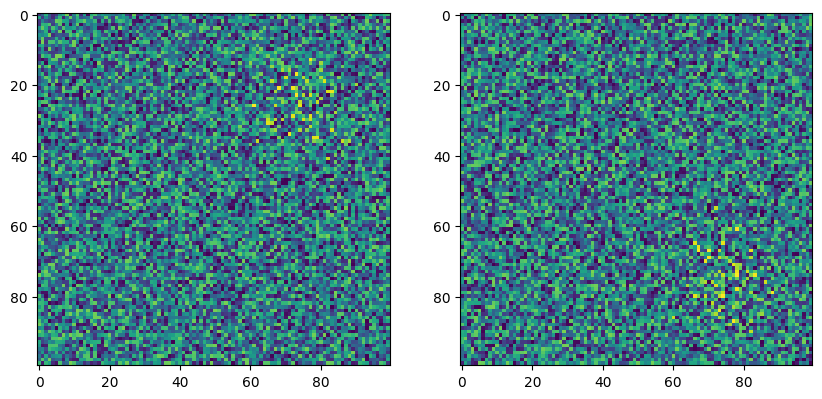

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(clases[0][0])
ax2.imshow(clases[1][0])

In [94]:
X = np.concatenate(clases)
Y = one_hot_encoder(np.concatenate([np.full((len(class_)), i) for i, class_ in enumerate(clases)]))
dataset = EpochsDataset((X, Y), savepath='../datasets/voxels', transform = zscore)
dataset.save('../data/planes.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [84]:
dataset = EpochsDataset.load('../data/planes.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

Text(0.5, 0.98, 'tensor([1., 0.])')

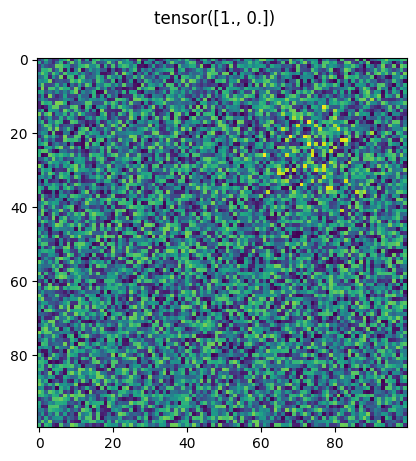

In [95]:
plt.imshow(dataset[0][0])
plt.suptitle(dataset[0][1])

In [96]:
from torch.utils.data import DataLoader

X, Y = next(iter(DataLoader(train, 2)))

In [60]:
X.shape

torch.Size([2, 100, 100])

In [97]:
from deepmeg.models import BaseModel

class CC1(BaseModel):
    def __init__(
        self,
        in_channels,
        out_channels,
        input_size,
        kernel_size,
        maxpool_size,
        n_classes: int,
        stride=1,
        padding=0,
    ):
        super().__init__()
        self.n_classes = n_classes
        self.rc = ResConv2D(in_channels, out_channels, input_size, kernel_size, stride, padding)
        convargs = (input_size, kernel_size, padding, stride)
        self.convout_shape = compute_output_shape(*convargs)
        self.maxpool = nn.MaxPool2d((maxpool_size, maxpool_size), maxpool_size)
        convargs = (self.convout_shape, (maxpool_size, maxpool_size), 0, maxpool_size)
        self.maxpool_shape = compute_output_shape(*convargs)
        self.num_features = np.prod(self.maxpool_shape)
        self.linear = nn.Linear(self.num_features, self.n_classes)


    def forward(self, x: torch.Tensor):
        x = torch.unsqueeze(x, 1)

        x = self.rc(x)
        x = self.maxpool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)

        return x

In [102]:
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback, EarlyStopping, L2Reg

model = CC1(
    in_channels=1,
    out_channels=1,
    input_size=(100, 100),
    kernel_size=(10, 10),
    maxpool_size=5,
    n_classes=2,
    stride=5
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        # L2Reg(
        #     [
        #         'rc.wave1', 'rc.wave2'
        #     ],
        #     0.01
        # ),
        EarlyStopping(monitor='loss_val', restore_best_weights=True, patience=15)
    ]
)

In [103]:
model.convout_shape, model.maxpool_shape, model.num_features

((19, 19), (3, 3), 9)

In [104]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

Epoch 0:  loss_train:  0.7267   |    binary_accuracy_train:  0.4988   |    loss_val:  0.7130   |    binary_accuracy_val:  0.5417
Epoch 1:  loss_train:  0.7088   |    binary_accuracy_train:  0.5231   |    loss_val:  0.7081   |    binary_accuracy_val:  0.5417
Epoch 2:  loss_train:  0.6955   |    binary_accuracy_train:  0.5619   |    loss_val:  0.7037   |    binary_accuracy_val:  0.5458
Epoch 3:  loss_train:  0.6844   |    binary_accuracy_train:  0.6081   |    loss_val:  0.6998   |    binary_accuracy_val:  0.5458
Epoch 4:  loss_train:  0.6748   |    binary_accuracy_train:  0.6350   |    loss_val:  0.6957   |    binary_accuracy_val:  0.5500
Epoch 5:  loss_train:  0.6648   |    binary_accuracy_train:  0.6450   |    loss_val:  0.6919   |    binary_accuracy_val:  0.5583
Epoch 6:  loss_train:  0.6558   |    binary_accuracy_train:  0.6644   |    loss_val:  0.6884   |    binary_accuracy_val:  0.6250
Epoch 7:  loss_train:  0.6475   |    binary_accuracy_train:  0.6731   |    loss_val:  0.6848   | 

[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

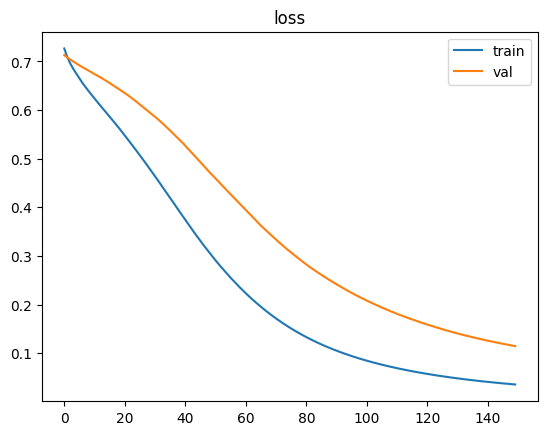

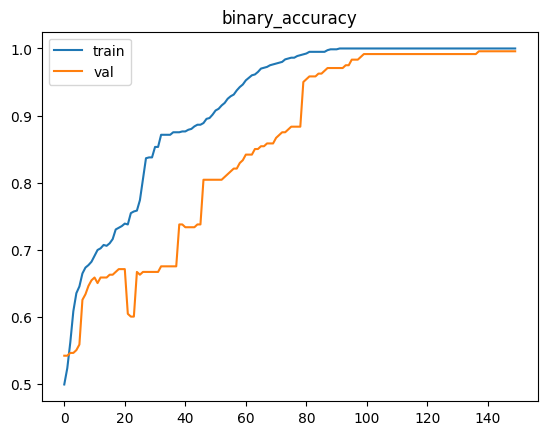

In [105]:
from deepmeg.utils.viz import plot_metrics

history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [106]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.0712435569614172
train_binary_accuracy: 0.9982142865657806
loss: 0.16567380875349044
binary_accuracy: 0.9541666686534882


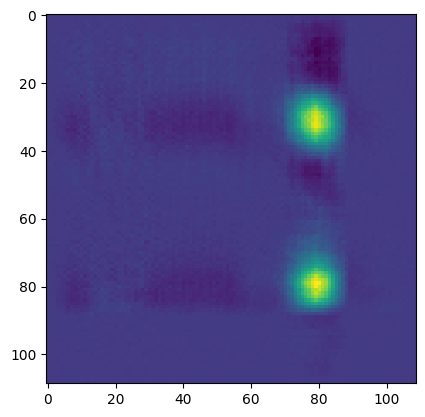

In [107]:
import scipy as sp

wave1, wave2 = torch.squeeze(model.rc.wave1.detach()).numpy(), torch.squeeze(model.rc.wave2.detach()).numpy()

plt.imshow(sp.signal.convolve2d(wave1, wave2))

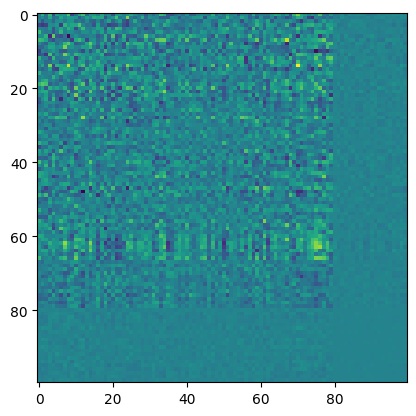

In [72]:
plt.imshow(wave2@wave1)

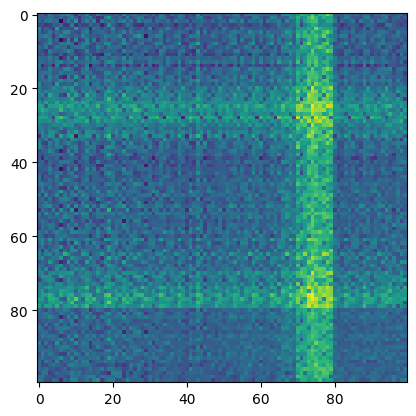

In [109]:
@torch.no_grad()
def get_mask(shape, model):
    convargs = ((shape[-2], shape[-1]), model.kernel_size, model.padding, model.stride)
    out_tensor = torch.zeros(*shape, model.out_channels)

    for n_neuron in range(model.out_channels):
        for p, q, k in conviter(*convargs):
            w1_slice = model.wave1[:, k[0], p[1], n_neuron]
            w2_slice = model.wave2[:, p[0], k[1], n_neuron]
            res = (w1_slice + w2_slice)
            out_tensor[p[-2], p[-1], n_neuron] = res

    return out_tensor

plt.imshow(torch.squeeze(get_mask((100, 100), model.rc)))

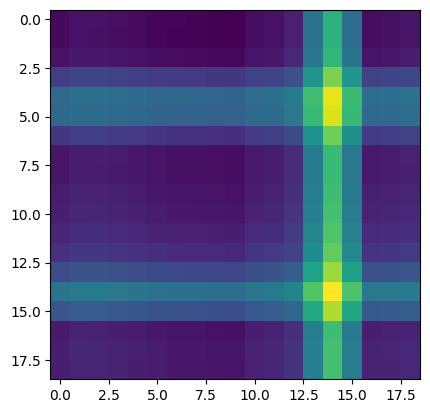

In [108]:
mask = model.rc(torch.ones(1, 1, 100, 100))
plt.imshow(torch.squeeze(mask).detach())
